## Introduction to Image Captioning

Image Captioning is a fascinating way for computers to describe images using words. Similar to how we glance at a picture and understand what's happening, computers can learn to do the same!


Imagine showing a computer an image of an adorable cat. Image Captioning is like magic that makes the computer say something like, "A fluffy white cat is sitting on a windowsill." It's a beautiful blend of teaching computers to comprehend images and communicate using human-like language.

## How It Works

Think of Image Captioning as a collaboration between two essential components of the computer's brain:



### The Eye (Convolutional Neural Networks - CNNs):

Just as we have eyes to see, computers have CNNs to analyze pictures. These networks help the computer identify important elements in the image, such as the cat's ears or tail. These key elements are translated into a special set of numbers that the computer understands. These special numbers are called "vector embeddings."



### The Mouth (Recurrent Neural Networks - RNNs):

The computer's "mouth" is the RNN. It takes those special numbers (vector embeddings) from the CNN and combines them with the power of words. It's as if we're teaching the computer to narrate a story about the image. The RNN takes one word at a time and starts forming a sentence. It begins with "Fluffy," followed by "white," and so on, until a complete description is created.



## Why It's Fascinating

Image Captioning empowers computers to describe images just like humans do. This enhances computers' image understanding capabilities and enables them to communicate using descriptive language. If you're curious to see how this collaboration looks in visual representation, check out the Modelling section!

In [4]:
!nvidia-smi

Mon Nov 11 07:16:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Importing the relevant libraries

In [5]:
# Basic libraries
import os
import pickle
import cv2, warnings
warnings.filterwarnings('ignore')
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from glob import glob
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm  # Progress bar library for Jupyter Notebook
tqdm.pandas()
import nltk
from sklearn.model_selection import train_test_split

# Deep learning framework for building and training models
import tensorflow as tf

# Pre-trained model for image feature extraction
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Optimizer for training the model
from tensorflow.keras.optimizers import Adam

# Class for defining Keras models
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, TimeDistributed, Embedding, Dropout, add, Concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda, Convolution2D

#To prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import regularizers

# Image Augumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For checking score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## Loading the images

In [6]:
# img_path = '/kaggle/input/flickr8k/Images/'
# images = glob(img_path+'*.jpg')
# images[:5]
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Resnet50

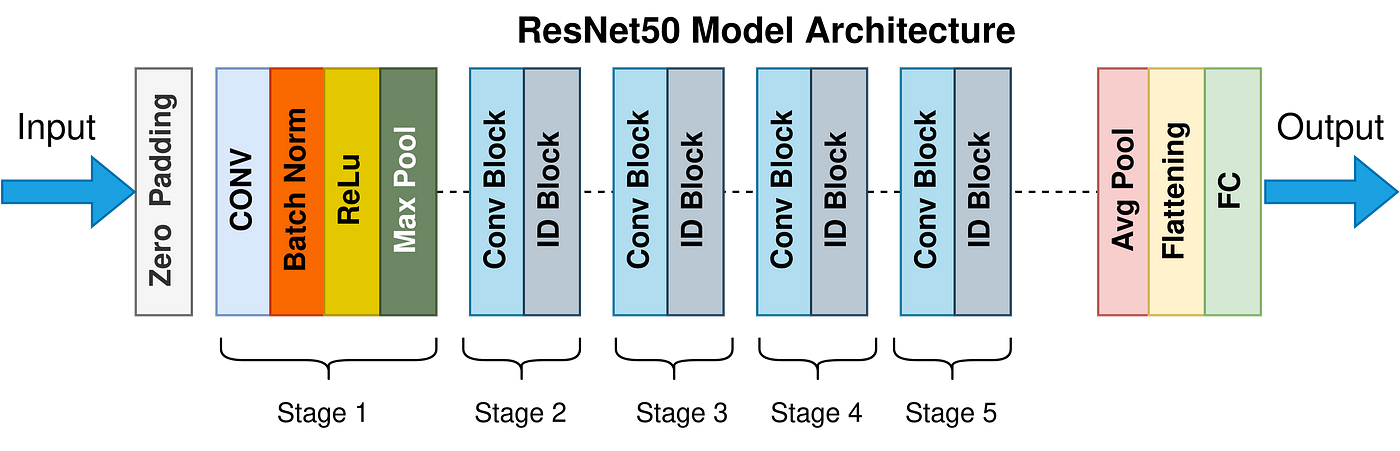


ResNet-50, a 50-layer deep convolutional neural network, is widely used in image captioning tasks for its strong feature extraction capabilities. Built on a residual learning framework, ResNet-50 efficiently captures complex visual features by using "shortcut" or residual connections, which help the model avoid issues like vanishing gradients in deep networks.



For image captioning, ResNet-50 serves as the backbone of the encoder in an encoder-decoder framework. It processes an input image to generate a rich, high-level feature map that captures essential visual details, which is then fed into a decoder (often an LSTM or Transformer) to produce descriptive captions.

## Downloading the ResNet50 inception model

In [7]:
# Load the ResNet50 model
model = ResNet50(include_top=True)

# Printing the model summary
model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [8]:
penultimate_layer_output = model.layers[-2].output  # Output of the penultimate layer
model = Model(inputs=model.input, outputs=penultimate_layer_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Image Features Extraction

In [9]:
# extract features from image
features = {}
IMAGE_DIR = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(IMAGE_DIR)):
    # load the image from file
    img_path = IMAGE_DIR + '/' + img_name
    # Load and preprocess the image
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
# Store features in a pickle file
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

print("features saved to", os.path.join(WORKING_DIR, 'features.pkl'))

features saved to /kaggle/working/features.pkl


In [11]:
# Load features from the pickle file
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    loaded_features = pickle.load(f)

print("Features loaded successfully")

Features loaded successfully


In [12]:
# List to store image names
image_names = []

# Loop through the files in the directory
for filename in os.listdir(IMAGE_DIR):
    # Check if the file is an image (optional, check by file extension)
    if filename.endswith(('.jpg')):  # Add any other image formats you need
        image_names.append(filename)

## Loading the captions

In [13]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

## Preprocessing the captions text

In [14]:
# # Create a dictionary where the key is the image filename and the value is a list of captions
# captions_dict = {}

# for cap in captions:
#     try:
#         image_id = cap.split(',')[0]
#         caption = cap.split(',')[1]
#         # Each image has 5 captions
#         if image_id in img_features:
#             if image_id not in captions_dict:
#                 captions_dict[image_id] = [caption] # Storing the first caption
#             else:
#                 captions_dict[image_id].append(caption) # Adding the remaining captions 
#     except:
#         break
# # To display the first image and its captions
# example = {key: captions_dict[key] for key in list(captions_dict)[:1]}
# print(example)

# create mapping of image to captions
image_to_captions_mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in image_to_captions_mapping:
        image_to_captions_mapping[image_id] = []
    # store the caption
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


In [15]:
image_to_captions_mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
def clean(image_to_captions_mapping):
    for key, captions in image_to_captions_mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Delete digits and special characters using regex
            caption = re.sub(r'[^a-zA-Z\s]', '', caption)
            # Remove additional spaces
            caption = re.sub(r'\s+', ' ', caption).strip()
            # Add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            # Update the caption in the list
            captions[i] = caption

In [17]:
# preprocess the text
clean(image_to_captions_mapping)

In [18]:
image_to_captions_mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
all_captions = []
for key in image_to_captions_mapping:
    for caption in image_to_captions_mapping[key]:
        all_captions.append(caption)

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
# # Create a list to store all captions after preprocessing
# all_preprocessed_captions = []

# # Storing the preprocessed text within the captions dictionary and appending it to the list
# for key, val in captions_dict.items():
#     for item in val:
#         preprocessed_caption = text_preprocess(item)
#         captions_dict[key][val.index(item)] = preprocessed_caption  # Update the caption in the dictionary
#         all_preprocessed_captions.append(preprocessed_caption)  # Add to the list

In [22]:
# # Print the list of all preprocessed captions
# print(all_preprocessed_captions[:5])  # Example: Display the first 5 preprocessed captions

In [23]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [24]:
vocab_size

8768

In [25]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

## Creating vocabulary of the entire text corpus

In [26]:
# count_words = dict()
# cnt = 1

# for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
#     for item in val: # Iterating through all captions for each image
#         for word in item.split(): # Iterating through all words in each caption
#             if word not in count_words:
#                 count_words[word] = cnt
#                 cnt += 1

In [27]:
# len(count_words) # Vocab size

In [28]:
# # Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
# for key, val in captions_dict.items():
#     for caption in val:
#         encoded = []
#         for word in caption.split():
#             encoded.append(count_words[word])
#         captions_dict[key][val.index(caption)] = encoded

In [29]:
# # Determining the maximum possible length of text within the entire captions text corpus
# max_len = -1

# for key, value in captions_dict.items():
#     for caption in value:
#         if max_len < len(caption):
#             max_len = len(caption)

In [30]:
# max_len

In [31]:
# vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
# vocab_size

## Train test split

In [32]:
# Split image IDs into training and test sets
image_ids = list(image_to_captions_mapping.keys())
split = int(len(image_ids) * 0.90)  # 90% for training, 10% for testing
train = image_ids[:split]
test = image_ids[split:]

In [33]:
# Further split the training data into training (90%) and validation (10%) sets
train_split = int(len(train) * 0.90)  # 90% of training data for training
train_data = train[:train_split]
val_data = train[train_split:]  # 10% of training data for validation

## Building a custom generator function to generate input image features, previously generated text and the text to be generated as output

In [34]:
# def generator(img,caption):
#     X = []
#     y_input = []
#     y_output = []
    
#     for key, val in caption.items(): 
#         for item in val: 
#             for i in range(1,len(item)):
#                 X.append(img[key]) # Appending the input image features
#                 input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
#                 output_seq = item[i] # The next word to be predicted as output
#                 # Padding encoded text sequences to the maximum length
#                 input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
#                 # One Hot encoding the output sequence with vocabulary size as the total no. of classes
#                 output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
#                 y_input.append(input_seq)
#                 y_output.append(output_seq)
    
#     return X, y_input, y_output

# Data Generator Function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []  # Lists to store image features (X1), input sequences (X2), and output sequences (y)
    n = 0  # Counter for the batch size
    while True:
        for key in data_keys:
            n += 1
            captions = image_to_captions_mapping[key]  # Get captions for the current image
            for caption in captions:
                # Convert the caption into a sequence of integers
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # Split the sequence into input (X2) and output (y) pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence to ensure consistent length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # One-hot encode the output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Append the current image features (X1), input sequence (X2), and output sequence (y)
                    X1.append(features[key][0])  # Image features
                    X2.append(in_seq)  # Input caption sequence
                    y.append(out_seq)  # Output caption (next word)
            
            # If batch size is reached, yield the data and reset for the next batch
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y  # Pass the correct input names
                X1, X2, y = [], [], []  # Reset lists
                n = 0

In [35]:
# X, y_in, y_out = generator(img_features,captions_dict)

In [36]:
# len(X), len(y_in), len(y_out)

In [37]:
# # Converting input and output into Numpy arrays for faster processing
# X = np.array(X)
# y_in = np.array(y_in,dtype='float64')
# y_out = np.array(y_out,dtype='float64')

In [38]:
# X.shape, y_in.shape, y_out.shape

## LSTM
We've got our image features, and we're ready to make our captions come to life. In this section, we'll be diving into the training of our LSTM model. This is where we teach our model to generate descriptive captions for our images.



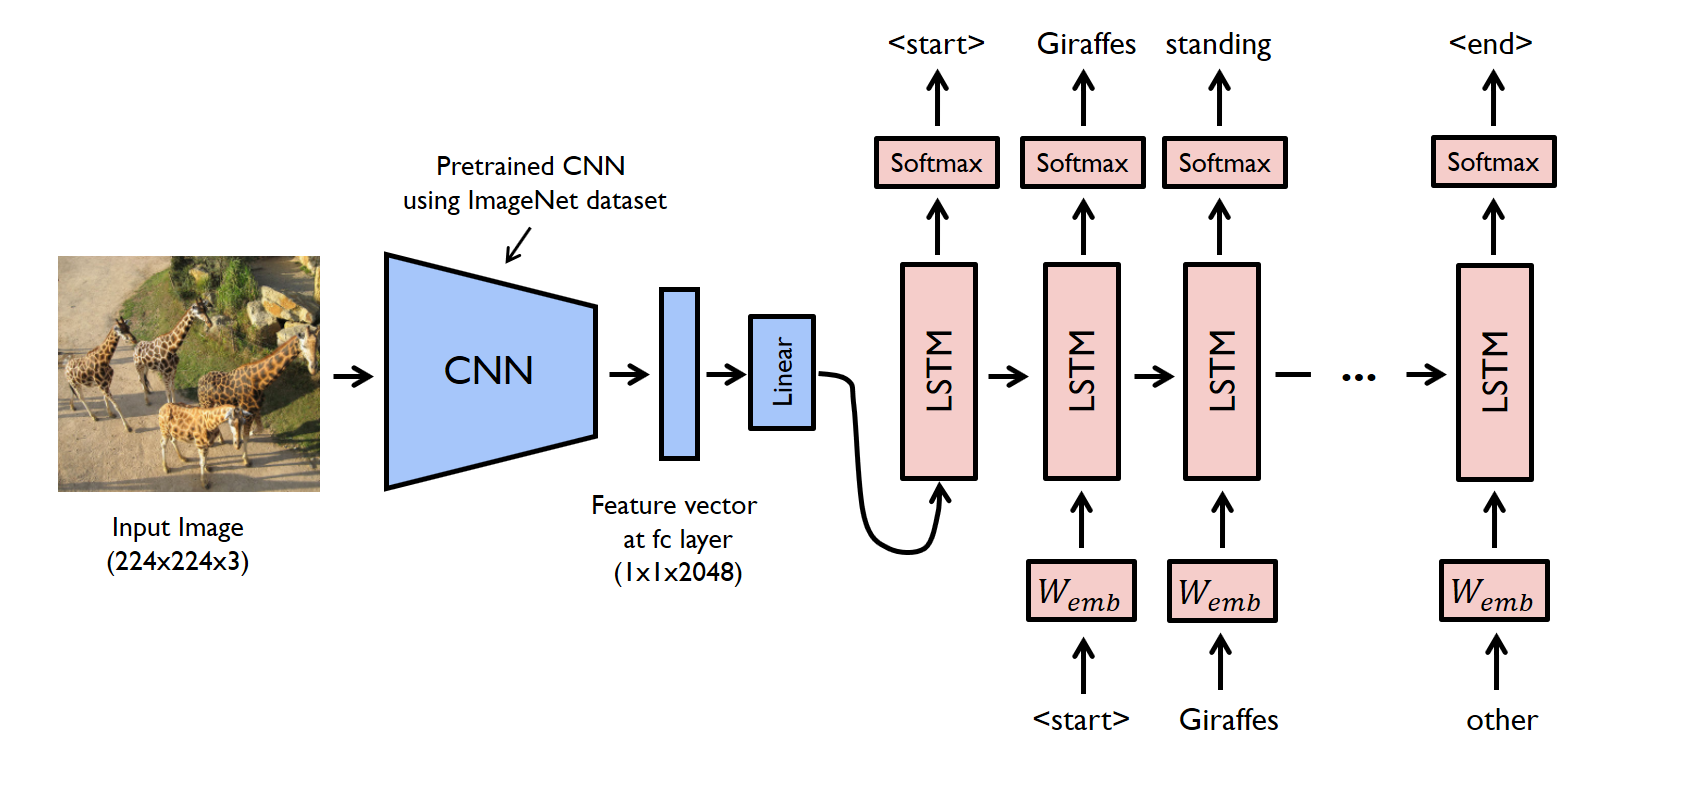

## Establishing the model architecture

In [39]:
# Define inputs
image_input = Input(shape=(2048,), name="image")  # Image features
caption_input = Input(shape=(max_length,), name="text")  # Caption sequence
# Process image features with a dense layer
image_features = Dense(256, activation='relu')(image_input)
image_features = Dropout(0.4)(image_features)
# Process caption input with an embedding layer and LSTM
caption_embedding = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
caption_lstm = LSTM(256)(caption_embedding)
caption_lstm = Dropout(0.4)(caption_lstm)
# Combine image features and caption LSTM output
merged = add([image_features, caption_lstm])
# Add a fully connected layer for prediction
decoder = Dense(256, activation='relu')(merged)  # Additional Dense layer
decoder = Dropout(0.4)(decoder)  # Dropout layer to prevent overfitting
# Define the output layer (prediction of next word)
output = Dense(vocab_size, activation='softmax')(merged)
# Build the model
model = Model(inputs=[image_input, caption_input], outputs=output)
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# Model summary
model.summary()


# # Define inputs
# image_input = Input(shape=(2048,), name="image")  # Image features (2048-dimensional for ResNet50)
# caption_input = Input(shape=(max_length,), name="text")  # Sequence of words (captions)
# # Process image features with a dense layer and dropout
# image_features = Dense(512, activation='relu')(image_input)  # Increased Dense layer size
# image_features = Dropout(0.4)(image_features)  # Dropout layer for regularization
# # Process caption input with embedding layer, LSTM, and dropout
# caption_embedding = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
# caption_lstm = Bidirectional(LSTM(256, return_sequences=False))(caption_embedding)  # Bidirectional LSTM
# caption_lstm = Dropout(0.4)(caption_lstm)  # Dropout layer
# # Project the LSTM output to the same shape as image features
# caption_lstm = Dense(512, activation='relu')(caption_lstm)
# # Combine image features and caption LSTM output
# merged = add([image_features, caption_lstm])  # Merge image and text features
# # Add a fully connected layer for prediction
# decoder = Dense(256, activation='relu')(merged)  # Additional Dense layer
# decoder = Dropout(0.4)(decoder)  # Dropout layer to prevent overfitting
# # Output layer (prediction of next word)
# output = Dense(vocab_size, activation='softmax')(decoder)
# # Build the model
# model = Model(inputs=[image_input, caption_input], outputs=output)
# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# # Print model summary
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 34)]         0           []                               
                                                                                                  
 image (InputLayer)             [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      2244608     ['text[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['image[0][0]']                  
                                                                                            

## Visualizing the model architecture

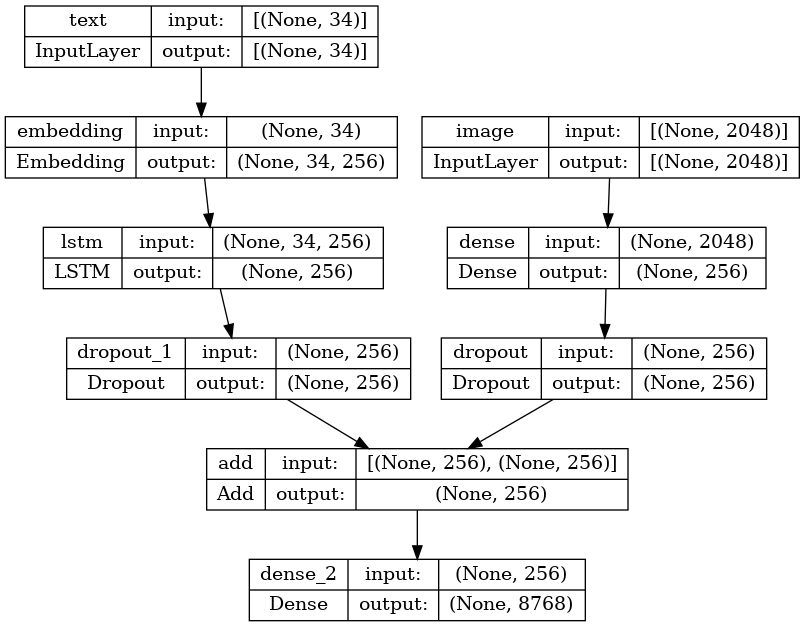

In [40]:
# plot the model
plot_model(model, show_shapes=True)

In [42]:
# Callbacks: EarlyStopping and ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Set batch size and number of epochs
batch_size = 32
epochs = 20

# Train the model
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

train_generator = data_generator(train_data, image_to_captions_mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(val_data, image_to_captions_mapping, features, tokenizer, max_length, vocab_size, batch_size)

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

Epoch 1/20
204/204 [==============================] - ETA: 0s - loss: 5.2892 - accuracy: 0.1568
Epoch 1: val_loss improved from inf to 4.45955, saving model to model_checkpoint.h5
204/204 [==============================] - 67s 296ms/step - loss: 5.2892 - accuracy: 0.1568 - val_loss: 4.4595 - val_accuracy: 0.2266
Epoch 2/20
204/204 [==============================] - ETA: 0s - loss: 4.0506 - accuracy: 0.2606
Epoch 2: val_loss improved from 4.45955 to 3.96278, saving model to model_checkpoint.h5
204/204 [==============================] - 48s 234ms/step - loss: 4.0506 - accuracy: 0.2606 - val_loss: 3.9628 - val_accuracy: 0.2745
Epoch 3/20
204/204 [==============================] - ETA: 0s - loss: 3.6207 - accuracy: 0.2938
Epoch 3: val_loss improved from 3.96278 to 3.78220, saving model to model_checkpoint.h5
204/204 [==============================] - 46s 226ms/step - loss: 3.6207 - accuracy: 0.2938 - val_loss: 3.7822 - val_accuracy: 0.2965
Epoch 4/20
204/204 [==============================

## Model training

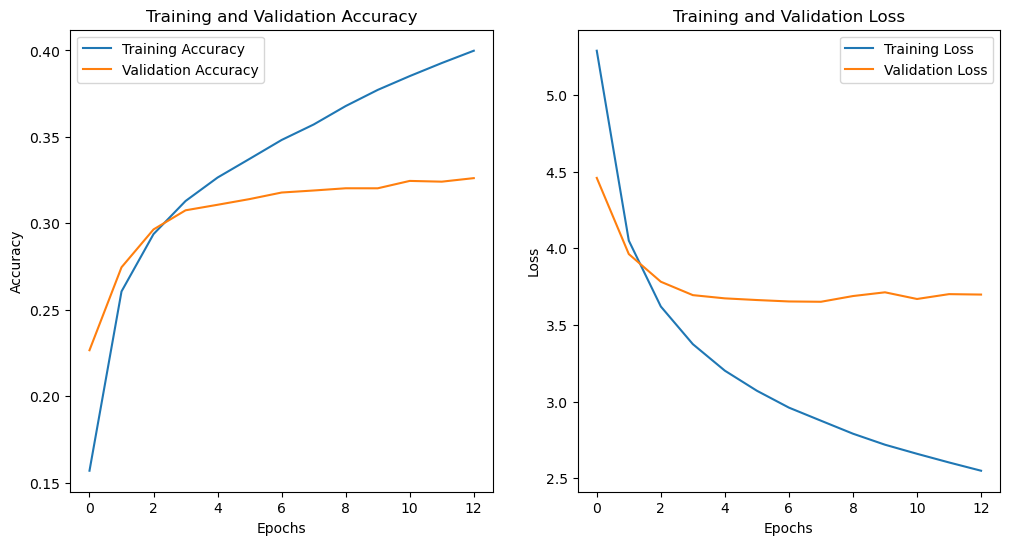

In [43]:
# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()

In [44]:
model.save('image_caption_generator_best.h5')

## Generating sample predictions

In [45]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [46]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [47]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = image_to_captions_mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.560692
BLEU-2: 0.342124


In [48]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy in his blue swim shorts at the beach endseq
startseq boy smiles for the camera at beach endseq
startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq
startseq children playing on the beach endseq
startseq the boy is playing on the shore of an ocean endseq
--------------------Predicted--------------------
startseq young boy in black and white shorts is running on the beach endseq


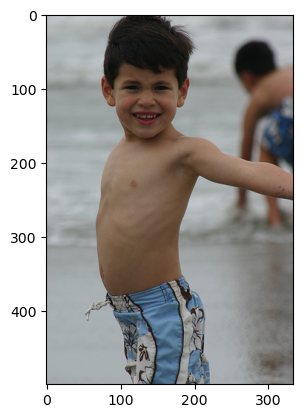

In [51]:
# # Select 5 random image names from the image_names list
# random_image_names = random.sample(image_names, 5)

# # Generate captions for each randomly selected image
# for image_name in random_image_names:
#     print(f"\nGenerating caption for image: {image_name}")
#     generate_caption(image_name)
#     plt.show()  # Display the image with its predicted caption

generate_caption("106490881_5a2dd9b7bd.jpg")